#### Task - Implement Logistic Regression Model

In [16]:
# Task 2 - Implement Logistic Regression Model
import numpy as np
class LogisticReg():
    def __init__(self,
                learning_rate=0.01,
                threshold=0.5, 
                num_iterations=1000,
                verbose = False):
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.num_iterations = num_iterations
        self.__n_features = None
        self.__N_samples = None
        self._weights = None
        self.verbose = verbose

    def __initialize(self, X, with_bias=False):
        if(with_bias):
            return X
        else:
            return np.c_[X, np.ones(X.shape[0])]
         
    def fit(self, X, y, with_bias=False) -> None:
        self.__N_samples, self.__n_features = X.shape
        self._weights = np.zeros(self.__n_features+1)
        X = self.__initialize(X, with_bias=with_bias) # add constant (bias) to X if needed
        # gradient decent
        for i in range(self.num_iterations):
            y_prob = self.__sigmoid(np.dot(X, self._weights)) # predict the probabilities
            gradient = (1/self.__N_samples) * np.dot(X.T, (y_prob - y))
            self._weights = self._weights - self.learning_rate*gradient # learning progress
            if self.verbose and (i % 25 == 0 or i == self.num_iterations-1): # print logloss if verbose is true
                loss = self.log_loss(y_prob,y)
                print(f"Loss after iteration {i}: {loss}")
            
    def predict_proba(self, X, with_bias=False):
        if(with_bias == False):
            X = self.__initialize(X, with_bias)  # add constance to X if needed
        return self.__sigmoid(np.dot(X, self._weights))
    
    def predict(self, X, with_bias=False,threshold=None):
        y_prob = self.predict_proba(X, with_bias) # predict probabilities
        if threshold is None:
            y_pred = np.where(y_prob < self.threshold, 0, 1) # return below 0.5 as 0 and upper as 1
        else:
            y_pred = np.where(y_prob < threshold, 0, 1)
        return y_pred
        
    def score(self, X, y,with_bias=False,threshold=None) -> float: # check accuracy score
        y_pred = self.predict(X,with_bias=with_bias,threshold=threshold) # predict labels
        correct = np.sum(y == y_pred) # checking right predictions
        return correct/len(y) # take the average of correct predictions
    
    def f1_score(self,y_true,y_pred):
        # create confusion table (true positive, false negative and false positive)
        tp = np.sum((y_true == 1) & (y_pred == 1)) # true positive
        fp = np.sum((y_true == 0) & (y_pred == 1)) # false positive
        fn = np.sum((y_true == 1) & (y_pred == 0)) # false negative
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * (precision * recall) / (precision + recall)
        return {'recall':recall,'precision':precision,'F1':f1}
    
    def __sigmoid(self,x):
        return 1/(1+np.exp(-x))

    def log_loss(self, y_pred_prob, y):
        epsilon = 1e-5  # to avoid from log(zero) adding epsilon
        return (-y * np.log(y_pred_prob + epsilon) - (1 - y) * np.log(1 - y_pred_prob + epsilon)).mean()

#### Task 3 - Run Logistic Regression Model on Dataset Spam/Ham - Imports

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
%matplotlib inline

In [18]:
# need to run only once
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\OmerK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\OmerK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Task 3 - Logistic Regression Model on Dataset Spam/Ham - Loading Data

In [19]:
# Task 3 - Run Logistic Regression Model on Dataset Spam/Ham - Loading Data
df = pd.read_csv('spam_ham_dataset.csv')
df.drop(['Unnamed: 0'],axis=1,inplace = True)
df.rename(columns={'label_num':'target'},inplace=True)
df['text'] = df['text'].replace(r'\n', ' ', regex=True) # remove \n

#### Task 3 - Logistic Regression Model on Dataset Spam/Ham - Preprocessing

In [20]:
# Add lens of text and show the information
# working on duplicate because after looking on this details it isn't looking helpful for prediction
df_dup = df.copy()
# this part take few seconds of run time
df_dup['num_characters'] = df_dup['text'].apply(len) # add more information about len of text
df_dup['num_words'] = df_dup['text'].apply(lambda text:len(nltk.word_tokenize(text)))
df_dup['num_sentences'] = df_dup['text'].apply(lambda text:len(nltk.sent_tokenize(text)))

##### Plot some data 
- this is not required but it is looking nice and help to understand a little more about the dataset

Ham:
       num_characters    num_words  num_sentences
count     3672.000000  3672.000000    3672.000000
mean       977.008170   226.239107      11.440904
std       1382.827493   332.179661      24.892442
min         18.000000     3.000000       1.000000
25%        231.750000    51.000000       3.000000
50%        530.000000   124.000000       6.000000
75%       1227.250000   294.000000      13.000000
max      32258.000000  8863.000000    1204.000000

Spam:
       num_characters    num_words  num_sentences
count     1499.000000  1499.000000    1499.000000
mean      1223.256171   236.387592      17.237492
std       1825.986210   346.821249      32.796043
min         11.000000     2.000000       1.000000
25%        283.000000    55.000000       4.000000
50%        576.000000   116.000000       9.000000
75%       1253.500000   244.000000      18.500000
max      22073.000000  3963.000000     693.000000

Both:
       num_characters    num_words  num_sentences
count     5171.000000  5171.000

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

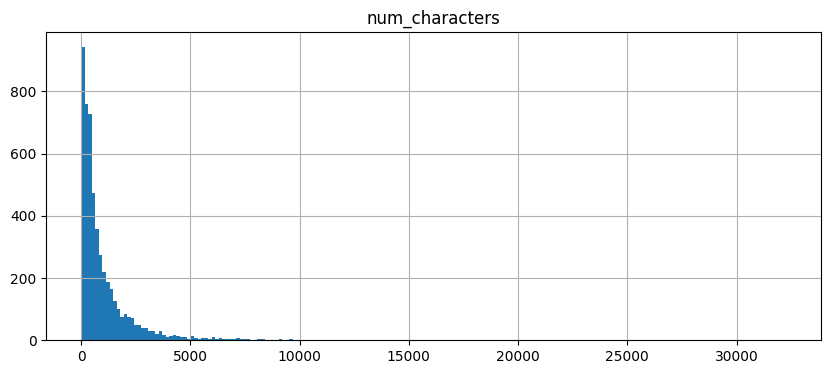

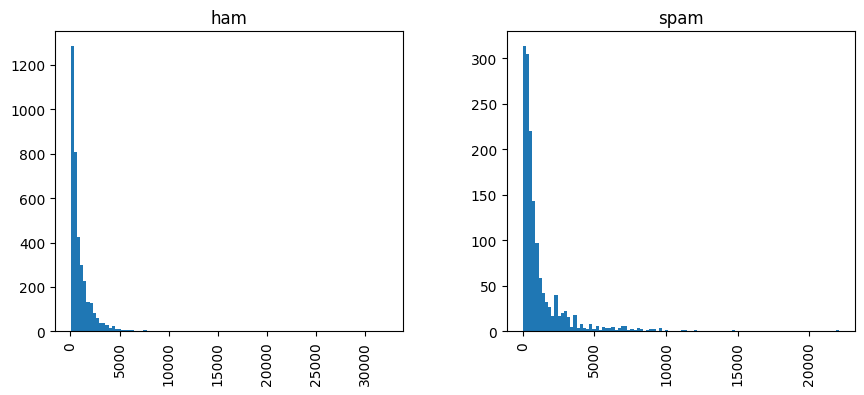

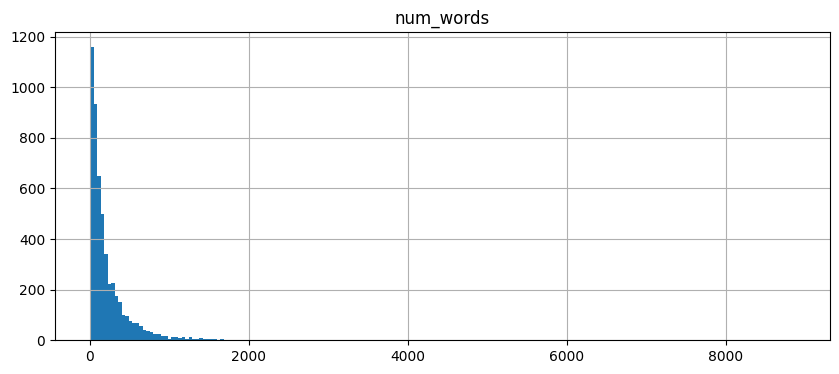

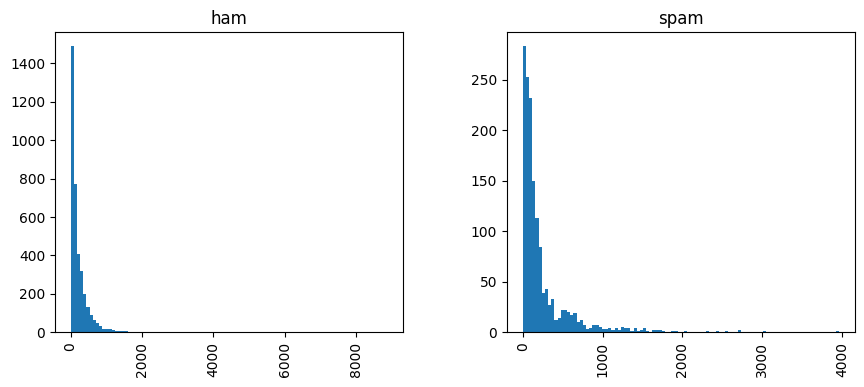

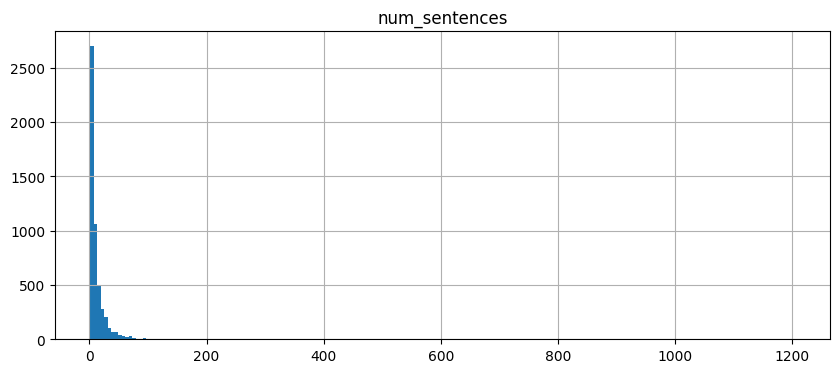

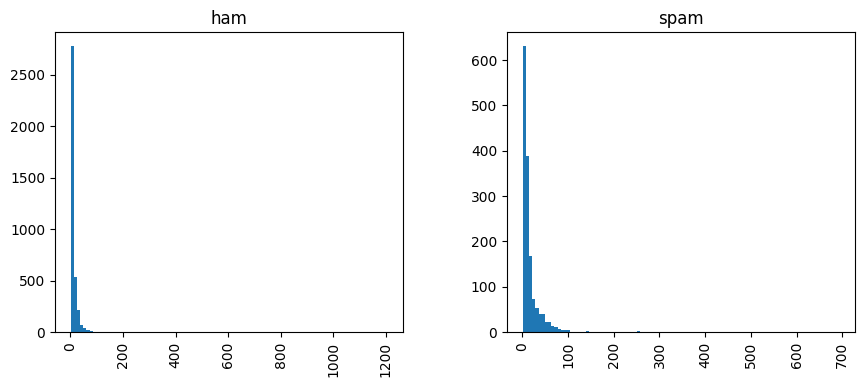

In [21]:
# Show the data informations
print("Ham:")
print(df_dup[df_dup['target'] == 0][['num_characters','num_words','num_sentences']].describe())
print("\nSpam:")
print(df_dup[df_dup['target'] == 1][['num_characters','num_words','num_sentences']].describe())
print("\nBoth:")
print(df_dup[['num_characters','num_words','num_sentences']].describe())

# plot the histogram of lens
df_dup.hist(column='num_characters',bins=200,figsize=(10,4),)
df_dup.hist(column='num_characters',by='label',bins=100,figsize=(10,4))
df_dup.hist(column='num_words',bins=200,figsize=(10,4))
df_dup.hist(column='num_words',by='label',bins=100,figsize=(10,4))
df_dup.hist(column='num_sentences',bins=200,figsize=(10,4))
df_dup.hist(column='num_sentences',by='label',bins=100,figsize=(10,4))

<Axes: xlabel='num_characters', ylabel='Count'>

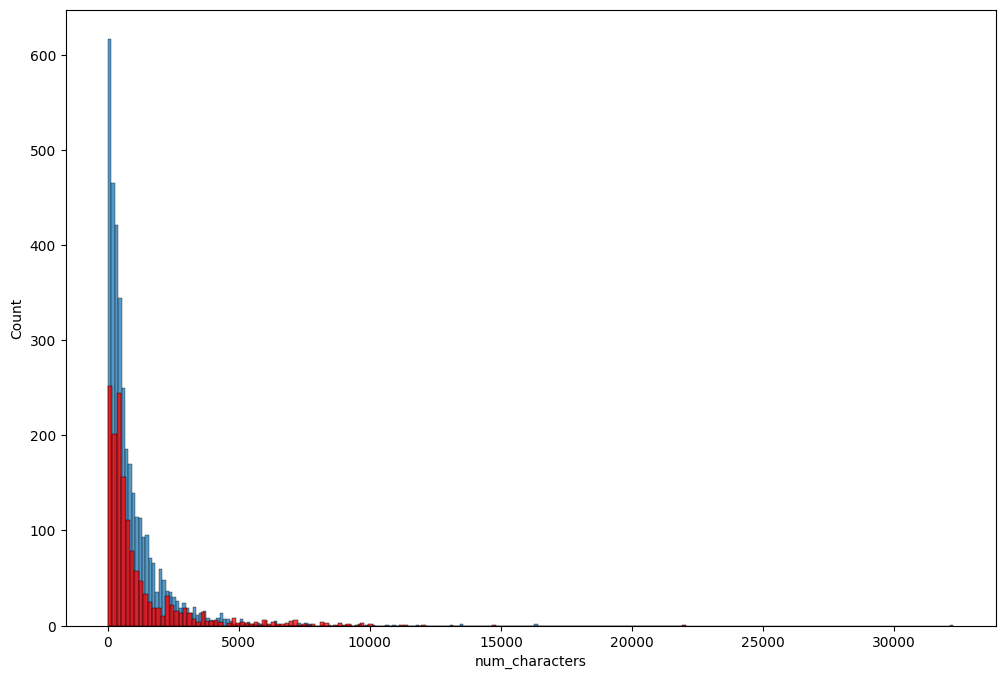

In [22]:
plt.figure(figsize=(12,8))
sns.histplot(df_dup[df_dup['target'] == 0]['num_characters'])
sns.histplot(df_dup[df_dup['target'] == 1]['num_characters'],color='red')

<Axes: xlabel='num_words', ylabel='Count'>

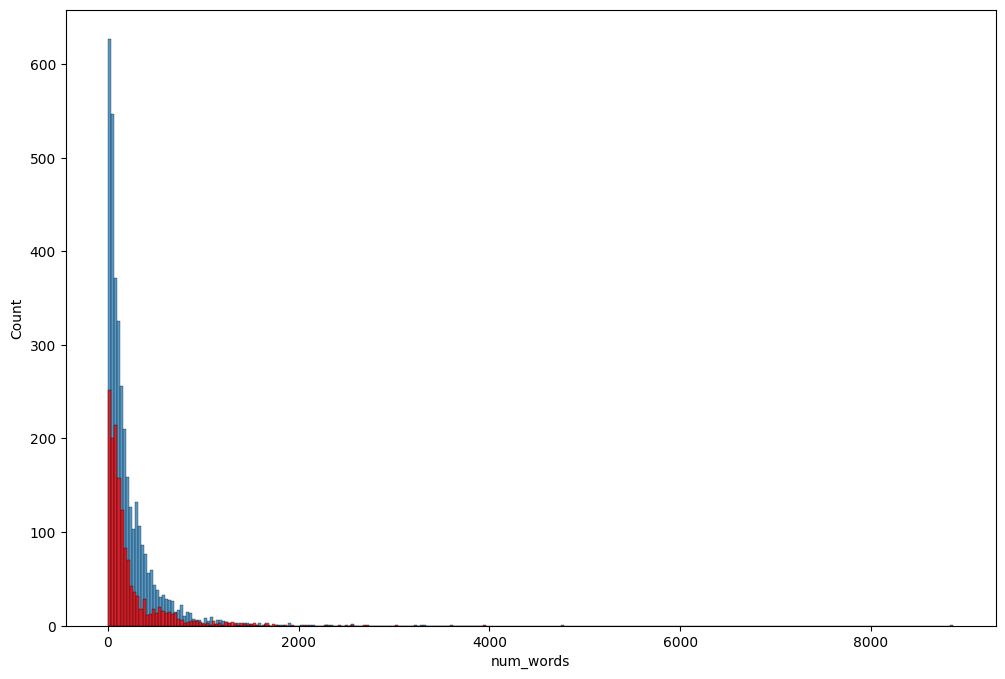

In [23]:
plt.figure(figsize=(12,8))
sns.histplot(df_dup[df_dup['target'] == 0]['num_words'])
sns.histplot(df_dup[df_dup['target'] == 1]['num_words'],color='red')

<Axes: xlabel='num_sentences', ylabel='Count'>

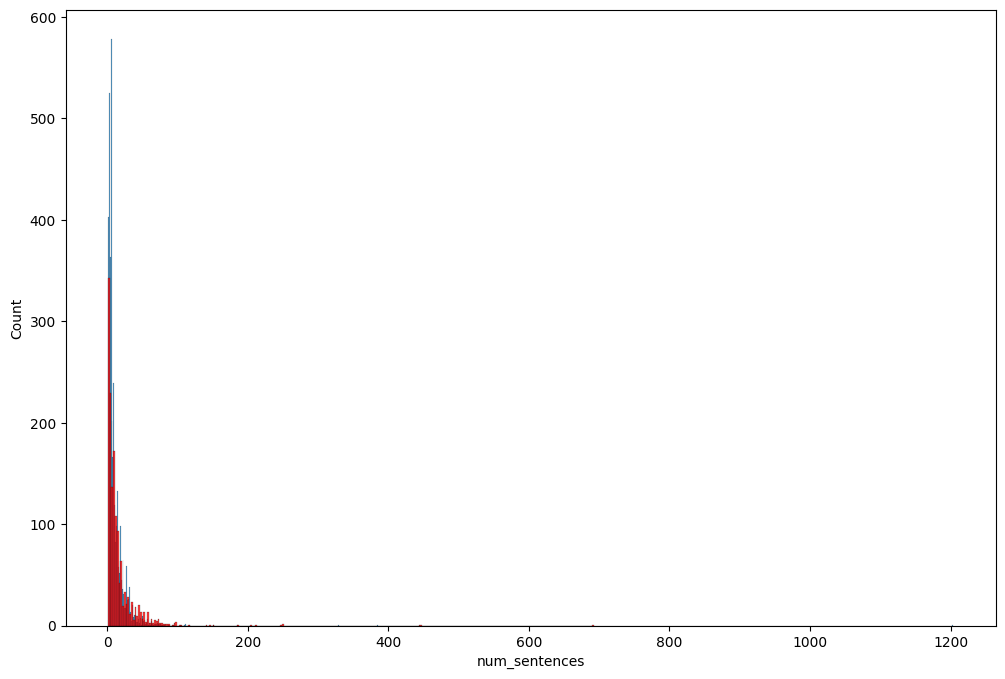

In [24]:
plt.figure(figsize=(12,8))
sns.histplot(df_dup[df_dup['target'] == 0]['num_sentences'])
sns.histplot(df_dup[df_dup['target'] == 1]['num_sentences'],color='red')

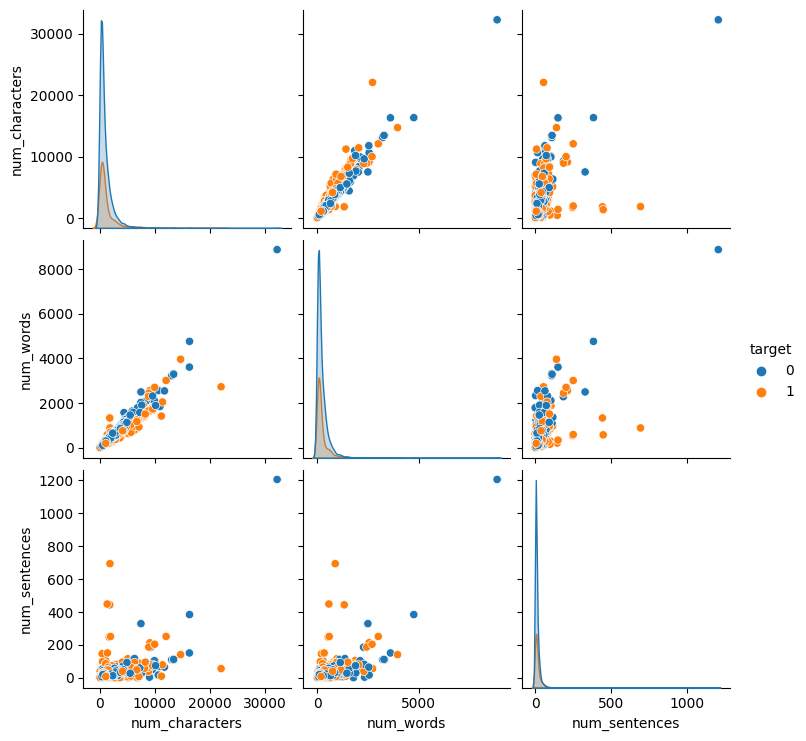

In [25]:
sns.pairplot(df_dup,hue='target')
df_withoutStrings = df_dup.drop(columns=['label','text'],inplace=False)

<Axes: >

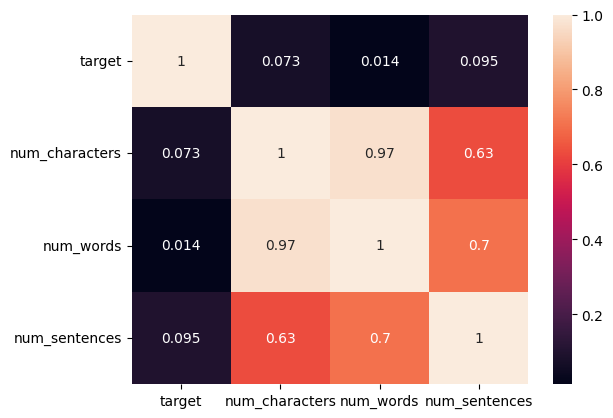

In [26]:
# Show correlation between lens and label
sns.heatmap(df_withoutStrings.corr(),annot=True)

##### Creating bag of words from dataset text

In [27]:
import re
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize) # for print the weight vector
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# Tokenization
def tokenize(text):
    # Split text by whitespace and remove punctuation with regex
    tokens = re.findall(r'(?u)\b\w\w+\b', text)
    return tokens

# Vocabulary creation
def create_vocab(corpus):
    # Count occurrence of each word in the entire corpus
    vocab_counts = Counter(word for text in corpus for word in text)
    # Create vocabulary from the words
    vocab = {word: i for i, (word, count) in enumerate(vocab_counts.most_common())}
    return vocab

# Counting word occurrences
def count_words(text, vocab):
    # Count occurrences of words in the text using a vocab
    word_counts = np.zeros(len(vocab), dtype=np.int32)
    for word in text:
        if word in vocab:
            word_counts[vocab[word]] += 1
    return word_counts

# Vectorization
def vectorize(corpus, vocab):
    N, n = len(corpus), len(vocab)
    vectors = np.zeros(shape=(N,n), dtype=np.int32)
    for i, text in enumerate(corpus):
        # Count word occurrences in document using a numpy array
        vector = count_words(text, vocab)
        vectors[i] = vector
    return vectors

# Split the data for train and test, shuffle disable by require.
X_train, X_test, y_trn, y_tst = train_test_split(df['text'], df['target'], train_size=0.8, shuffle=False)

# Create corpus to train and test
corpus_X_train = [tokenize(text.lower()) for text in X_train] # Tokenize corpus from the text in X_train
corpus_X_test = [tokenize(text.lower()) for text in X_test] # Tokenize corpus from the text in X_test

# Create vocabulary from corpus of only from X_train
vocab = create_vocab(corpus_X_train)

# Vectorize X_train and X_test using vocabulary of X_train
X_trn = vectorize(corpus_X_train, vocab)
X_tst = vectorize(corpus_X_test, vocab)


##### Run the logistic regression model on the dataset and show results

Loss after iteration 0: 0.6931271807599426
Loss after iteration 25: 0.28800277447672834
Loss after iteration 50: 0.23659332296850408
Loss after iteration 75: 0.20707931131918883
Loss after iteration 100: 0.18697320044343954
Loss after iteration 125: 0.17205645555785787
Loss after iteration 150: 0.16038244134284763
Loss after iteration 175: 0.1509008963471967
Loss after iteration 199: 0.14327848184452102
-------------- Scores --------------
Accuracy Score: 0.9690821256038648
F1 Score: {'recall': 0.9472049689440993, 'precision': 0.953125, 'F1': 0.9501557632398754}
Log Loss: 0.1587397603778535
------------------------------------


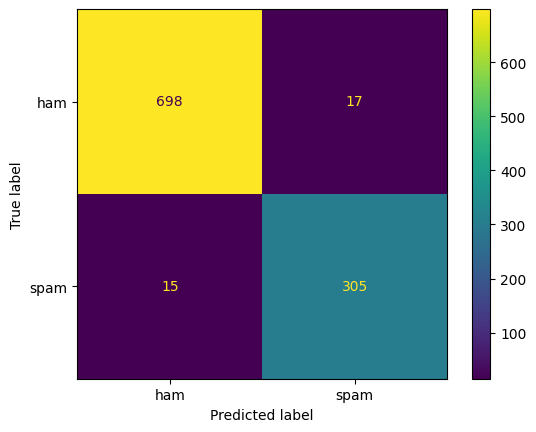

<Figure size 800x600 with 0 Axes>

In [28]:
clf = LogisticReg(learning_rate=0.1,num_iterations=200,verbose=True) # explain below
clf.fit(X_trn,y_trn)
y_tst_pred = clf.predict(X_tst)
# printing Scores for see the results of the model
print('-------------- Scores --------------')
print(f'Accuracy Score: {clf.score(X_tst,y_tst)}')
print(f'F1 Score: {clf.f1_score(y_tst_pred,y_tst)}')
print(f'Log Loss: {clf.log_loss(clf.predict_proba(X_tst),y_tst)}')
print('------------------------------------')
# plot confusion matrix
cm = confusion_matrix(y_tst,y_tst_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['ham','spam'])
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()

In [29]:
print(f'The weights vector:\n{clf._weights}')

The weights vector:
[-1.21058466e-01 -1.22263101e-01 -2.00934627e-01  9.35892683e-02
 -1.79288692e-01  1.84377188e-01  8.52945380e-02  9.05492667e-03
  1.82614929e-01 -1.06920105e-01 -1.47621484e-01  1.25693855e-02
  6.11129544e-02 -5.07023393e-01 -6.30611696e-02 -1.75629773e-02
  3.51906354e-02 -3.86344390e-01 -2.29358801e-01 -4.86770471e-02
 -1.52767755e-01  1.33866163e-01  6.03979610e-02 -7.85579992e-02
 -2.54436052e-01  1.57607878e-02  7.70049163e-02 -2.71515864e-01
  2.59220124e-02 -1.89955559e-01 -2.92185353e-01 -1.12874073e-02
  9.83616174e-02 -2.43961431e-02 -3.34432843e-01 -1.24058092e-01
 -1.15377776e-01 -3.16221692e-01 -5.04059756e-02 -8.00776932e-02
 -3.98928723e-01 -1.38561115e-01 -1.11060404e-01 -2.97965364e-01
 -1.80552057e-01  1.33428588e-01 -2.78912049e-03  1.06918566e-03
 -9.91014058e-02  1.18552213e-01 -3.25317196e-01 -2.55193169e-01
 -1.43716306e-01 -5.23070392e-02 -1.63148785e-02 -5.30168339e-02
 -2.16624702e-01  7.45677882e-02 -6.50384333e-02  1.64338007e-02
 -7.1

**Motivation to choose parameters**
- I shuffled (re-split and run) few times to see consistency of scores.
-  For decide which predictions are good, I used accuracy score and F1 score with confustion table.
    - I added verbose flag to the model for printing the log loss function of predictions to see the progress of learning.
    - I chose parameters when I got F1 Score (around 95%+). When I saw that while parameters changed one of scores went up but the second went down and scores didn't rise significantly for benefit of 
 prediction.
- The learning rate is 0.1 after trying different values and see that lead to good results in most of tests.
-  The num_iterations is 200 because less usually not enough for reach a good results and higher number is not increase the score in significant value but take a longer time to fit the model. in addition sometimes higher number of iterations lead to unbalance score between recall and precision.
- Maybe we will perfer less false positive predictions over less false negative predictions as a dependence of the purpose of the prediction and it will effect on the hyperparameter. In our case I perfer a balance between recall and precision scores.



#### Task 4 - ROC Cruve on Logistic Regression

The good threshold train: 0.45
The good threshold test: 0.44


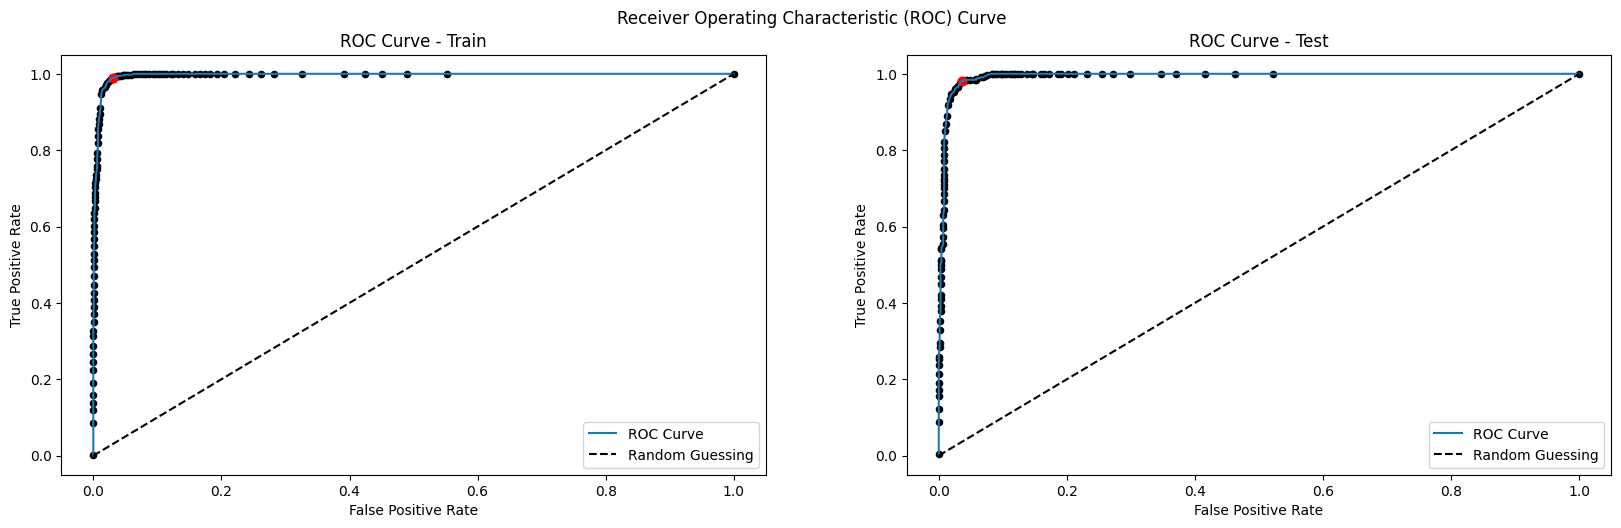

In [30]:
def plot_roc_curve(y_true, y_prob, ax, title):
    # Compute true positive rate (TPR) and false positive rate (FPR) for different thresholds
    thresholds = np.linspace(0, 1, 101)
    tpr_values = []
    fpr_values = []
    num_positive_cases = sum(y_true)
    num_negative_cases = len(y_true) - num_positive_cases
    for threshold in thresholds:
        y_pred = np.where(y_prob < threshold, 0, 1)
        tp = np.sum((y_true == 1) & (y_pred == 1)) # true positive
        fp = np.sum((y_true == 0) & (y_pred == 1)) # false positive
        tpr = tp / num_positive_cases # create tpr score (recall)
        fpr = fp / num_negative_cases # create fpr score (missing rate)
        # record the scores
        tpr_values.append(tpr)
        fpr_values.append(fpr)
    # change the list to np array for aritmetic between arrays
    tpr_values = np.array(tpr_values)
    fpr_values = np.array(fpr_values)
    # pickup the most the most successful theshold
    good_index = np.argmax(tpr_values-fpr_values) # find the most successful theshold index
    good_threshold = thresholds[good_index] # keep the value
    # Plot the ROC curve
    ax.plot(fpr_values, tpr_values, label=f'ROC Curve')
    ax.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    ax.scatter(fpr_values, tpr_values,s=20, color='black')
    ax.scatter(fpr_values[good_index], tpr_values[good_index], marker='o', facecolors='red', edgecolors='red', s=40)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {title}')
    ax.legend(loc='lower right')
    return good_threshold


fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=1, top= 0.95)
fig.suptitle('Receiver Operating Characteristic (ROC) Curve')
ax1 = fig.add_subplot(2,2,1)
good_threshold_train= plot_roc_curve(y_trn,clf.predict_proba(X_trn), ax1, 'Train')
ax2 = fig.add_subplot(2,2,2)
good_threshold_test= plot_roc_curve(y_tst,clf.predict_proba(X_tst), ax2, 'Test')
print(f'The good threshold train: {good_threshold_train:.2f}')
print(f'The good threshold test: {good_threshold_test:.2f}')
plt.show()


-------------- Scores --------------
Accuracy Score: 0.9690821256038648
F1 Score: {'recall': 0.9285714285714286, 'precision': 0.975, 'F1': 0.951219512195122}
Log Loss: 0.1587397603778535
--------- threshold:  0.45 ---------


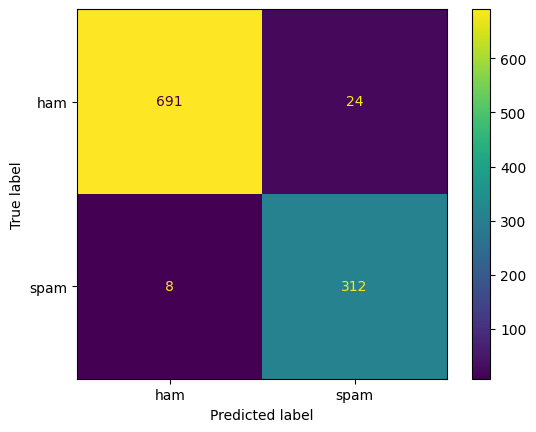

<Figure size 800x600 with 0 Axes>

In [39]:
# printing Scores for see the results of the model with threshold from ROC Curve
y_tst_pred = clf.predict(X_tst,threshold=good_threshold_train)
print('-------------- Scores --------------')
print(f'Accuracy Score: {clf.score(X_tst,y_tst,threshold=good_threshold_train)}')
print(f'F1 Score: {clf.f1_score(y_tst_pred,y_tst)}')
print(f'Log Loss: {clf.log_loss(clf.predict_proba(X_tst),y_tst)}')
print(f'--------- threshold:  {good_threshold_train} ---------')
# plot confusion matrix
cm = confusion_matrix(y_tst,y_tst_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['ham','spam'])
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()

**ROC Curve Conclusions**
- In looking on the ROC Curve we can see the the most successful theshold in the interval [0,1] with 101 numbers is usualy around 0.45-0.5 so we should take something in the middle as our theshold
    - For this datasets **without shuffle** we got that 0.45 is optimal threshold for high precision score according to the train set.
    - While the dataset was shuffled before spliting to train and test we got graphs that seem more similar to each other between train and test 
    - In this case **without shuffle** before split we can see a little of different between the graph (we didn't see when we shuffled) that may to indicate for less balanced data between train and test sets from when we used shuffle before split.
- The red mark show the place of the threshold on the plot.
- Note: I think that I would not take 0.45 as threshold and I would take a value more close to 0.5 because for my opinition classification of email to spam while is ham is worse from classification of spam email as a ham email so I will perfer take high recall score or balanced score between recall and precision.

#### Task 5 - Linear Programing

In [32]:
# Task 5 - Section 2 - Imports
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

**Task 5 - Linear Programing Data Generator**
###### I left the datasets i created for this task to check my code

In [33]:
# Dataset1 - Linear line with noise

# Define a linear line
a, b = (2, 0)
line = lambda x: a * x + b
# Generate random points close to the line
n_samples, noise_scale = 1000, 10.0
x_1 = np.linspace(-10, 10, n_samples)
x_2 = line(x_1) + np.random.normal(loc=0, scale=noise_scale, size=n_samples)
# Create input features X and labels y
X = np.column_stack((x_1, x_2))  # make X matrix of points
y = np.where(x_2 >= line(x_1), 1, -1)  # change y represent labels

# Flip a random subset of labels to be wrong
num_wrong_labels = y[y==1].shape[0] - 50
y_pos = y == 1
idx = np.random.choice(np.where(y_pos)[0], num_wrong_labels, replace=False)
y[idx] = -1

In [34]:
# Dataset2 Simple Dataset
X = np.array([[1,0],[2,1],[3,-1],[2,4],[1,3],[3,2],[-2,4]])
y = np.array([-1,-1,-1,-1,1,1,1])

In [35]:
# Dataset3 - logic gate dataset

# Define the parameters of the dataset
num_samples, noise_scale = 1000, 10.0
low, high = -10.0, 10.0  # Range of points
# Generate the data
X = np.random.uniform(low=low, high=high, size=(num_samples, 2))
# Add some noise to the labels
y = np.logical_or(X[:, 0] > 0, X[:, 1] > 0).astype(int)
y = np.where(y == 0, -1, y)

**Task 5 - Linear Programing**


In [36]:
N, n= X.shape
# Create A_ub, b_ub, c for LP
obj = np.concatenate([np.zeros(n),np.ones(N)])  # vector c
lhs_ineq = np.concatenate([-y*np.eye(N)@X,-np.eye(N)],axis=1) # matrix A
rhs_ineq = np.array([-1] *N) # vector B
#            bounds for points             bound for support vector
bnd = [(-float("inf"), float("inf"))] *n + [(0, float("inf"))] * N

opt = linprog(c=obj,
            A_ub=lhs_ineq,
            b_ub=rhs_ineq, 
            bounds=bnd,
            method="highs")
print(opt)  # print result of program

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 501.36013303350563
              x: [ 1.873e-01  1.756e-01 ...  0.000e+00  0.000e+00]
            nit: 575
          lower:  residual: [       inf        inf ...  0.000e+00
                              0.000e+00]
                 marginals: [ 0.000e+00  0.000e+00 ...  1.000e+00
                              1.000e+00]
          upper:  residual: [       inf        inf ...        inf
                                    inf]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          eqlin:  residual: []
                 marginals: []
        ineqlin:  residual: [ 0.000e+00  9.938e-01 ...  1.235e+00
                              2.295e+00]
                 marginals: [-1.000e+00 -0.000e+00 ... -0.000e+00
                             -0.000e+00]
 mip_node_count: 0
 mip_dual_bound: 0.0
        mi

**Task 5 - Linear Programing - plot the results** 

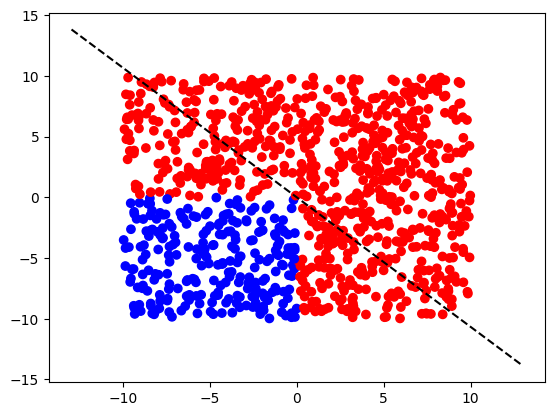

In [37]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(['blue','red']))
x_min, x_max, y_min, y_max = np.amin(X[:, 0]), np.amax(X[:, 0]), np.amin(X[:, 1]), np.amax(X[:, 1])

lx = np.linspace(x_min-3, x_max+3, 100)
w = opt.x
ly = [ -w[0] * p / w[1] for p in lx]

plt.plot(lx, ly,'k--')
plt.show()